In [1]:
import torch
import torchnmf
import matplotlib.pyplot as plt
import tqdm 
import numpy as np
import os
import skimage.io as iio
from tqdm import tqdm

In [2]:
# load in some data to be factorized
path = '/home/nrt2124/engram/cuttlefish/CUTTLEFISH_BEHAVIOR/cuttle_data_storage/2024_Interesting_skin_compiled_dataset/Nice skin manual crops/Lightroom Export_full res/'
files = np.sort(os.listdir(path))
images = iio.ImageCollection(path + '/*.tif')
cuts = [1080, 720]
cut_0 = cuts[0]
cut_1 = cuts[1]

shapes = np.empty((3, len(images)))
for i, image in enumerate(tqdm(images)):
   for j in range(3):
      shapes[j,i] = image.shape[j]

mask_0 = shapes[0,:] > cut_0
mask_1 = shapes[1,:] > cut_1

index_mask0 = np.where(mask_0 == True)[0]
index_mask1 = np.where(mask_1 == True)[0]

full_mask = np.intersect1d(index_mask0, index_mask1)

#first filter out unusually small images
print(len(images))
images_cut = [images[i] for i in full_mask]
print(len(images_cut))
print(len(full_mask))

100%|██████████| 430/430 [00:05<00:00, 75.77it/s]


430
382
382


In [3]:
def crop_image_to_size(image, output_size):
    height, width, c = image.shape


    # Desired output size
    new_height, new_width = output_size


    # Calculate coordinates to crop at the center
    start_x = (width // 2) - (new_width // 2)
    start_y = (height // 2) - (new_height // 2)

    # Crop the image
    cropped_img = image[start_y:start_y+new_height, start_x:start_x+new_width]
    return cropped_img



cropped_ims  = []
for image_cut in tqdm(images_cut):
    cropped_ims.append(crop_image_to_size(image_cut, (cut_0, cut_1)))

100%|██████████| 382/382 [00:00<00:00, 314038.44it/s]


In [4]:
#implement nmf on some data:

#Now for NMF
dataset = np.asarray(cropped_ims)

#grayscale data
gray_data = 0.2989*dataset[:,:,:,0] + 0.5870*dataset[:,:,:,1]+0.1140*dataset[:,:,:,2]

gray_data_flattened = gray_data.reshape(gray_data.shape[0], -1)
print(gray_data_flattened.shape) #382 flattend images :)


(382, 777600)


In [5]:
# now for gpu stuff!
from torchnmf.nmf import NMF
V = torch.tensor(gray_data_flattened)


model = NMF(V.shape, rank=382)
print(model.W.size())
print(model.H.size())




torch.Size([777600, 382])
torch.Size([382, 382])


In [6]:
#move to the gpu
V = V.cuda()
model = model.cuda()

In [8]:
model.fit(V)

200

In [9]:
model = model.cpu()
W = model.W.detach().numpy()
H = model.H.detach().numpy()

In [11]:
WH = W @ H.T

In [12]:
# reshape to images
features_images = np.empty((H.shape[0], gray_data.shape[1], gray_data.shape[2]))
for i, factor in enumerate(W.T):
    features_images[i] = factor.reshape(gray_data.shape[1], gray_data.shape[2])

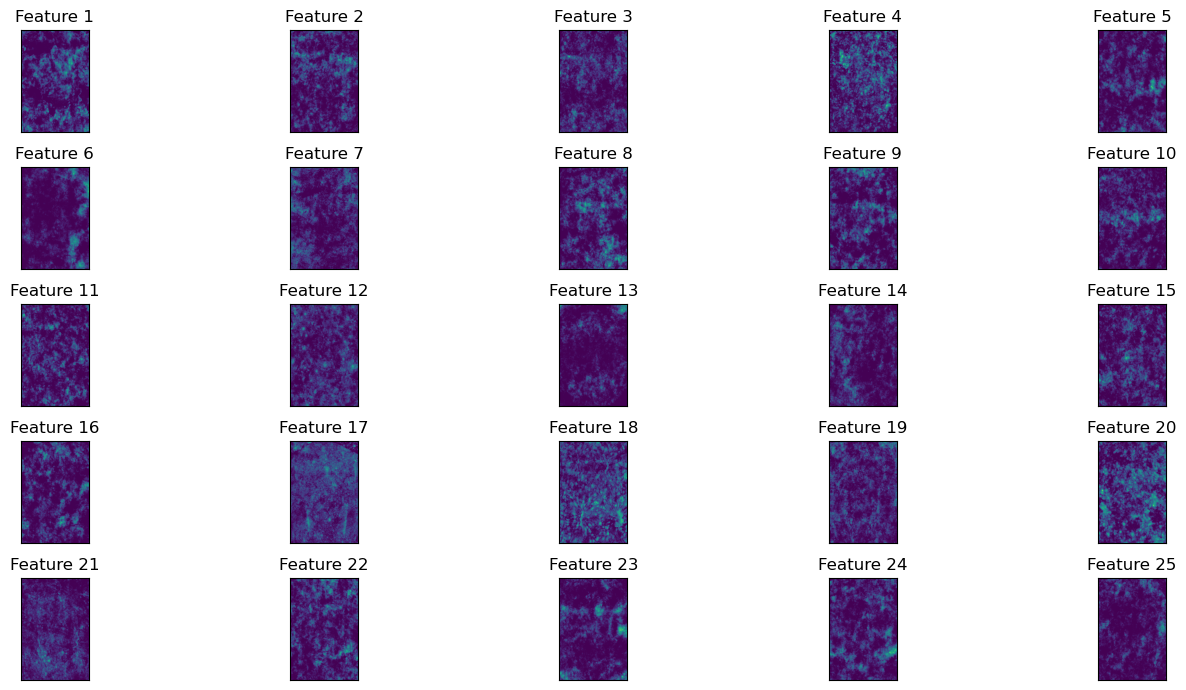

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(features_images[i+25])
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

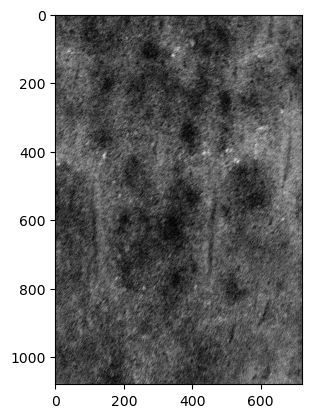

torch.Size([1, 777600])


In [14]:
#decompose a single image and see the reconstruction

gray_image = gray_data[4]
plt.imshow(gray_image, cmap = 'gray')
plt.show()
flat_image = gray_image.reshape(1,-1)
flat_image = torch.tensor(flat_image)
print(flat_image.shape)

In [51]:

flat_image = flat_image.type(torch.float64)
print(flat_image.dtype)
print(model.W.dtype)


torch.float64
torch.float32


In [53]:
W1 = model.forward(flat_image.type(torch.float32), W = model.W.T)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

IndexError: tuple index out of range

<Figure size 1500x800 with 0 Axes>

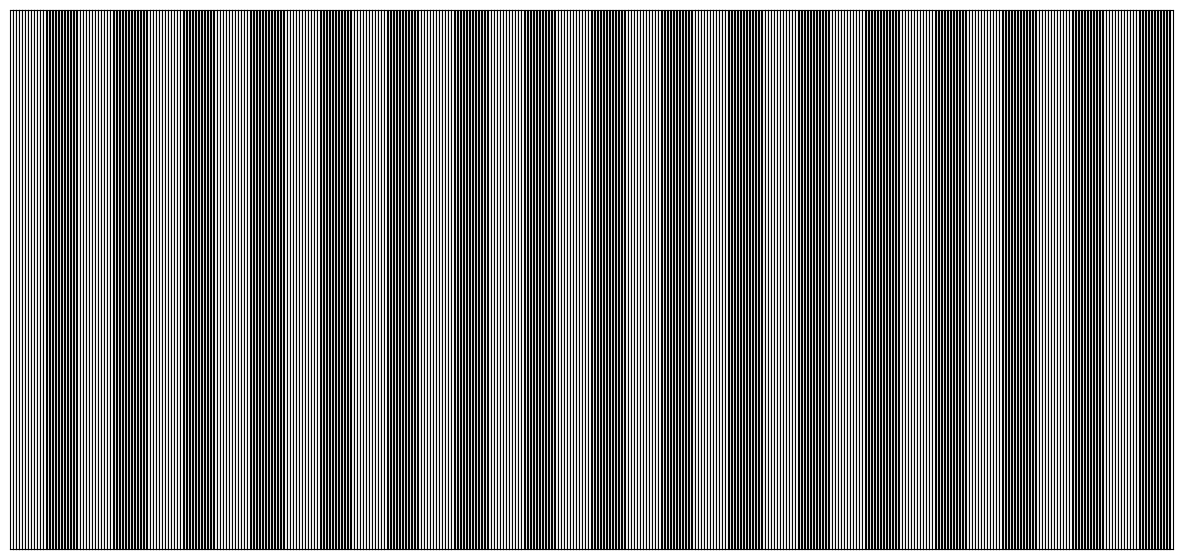

In [60]:
w = W1
gray_components = model.H

plt.figure(figsize=(15, 8))
num_components = gray_components.shape[0]
useful_components = np.where(w>=0.5)[1]

print(useful_components)

fig, axes = plt.subplots(1,len(useful_components), figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    component = useful_components[i]
    ax.imshow(w[component].reshape(gray_image.shape[1], gray_image.shape[2]), cmap='gray')
    ax.set_title(f'Feature {useful_components[i]+1}')
plt.tight_layout()
plt.show()

In [44]:
# help(model)